In [1]:
# important libraries
import time
from pynq import Overlay
from pynq import MMIO
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats

In [2]:
# load our overlay and quick peek inside for available hardware
thing = Overlay("design_1.bit")
thing.ip_dict.keys()

dict_keys(['buttons', 'leds', 'switches', 'frog', 'axi_quad_spi_0', 'processing_system7_0'])

In [3]:
# configure all the debug GPIO
try:
    led_address = thing.ip_dict['leds']['phys_addr']
    leds = MMIO(led_address, 8)
    leds.write(0x4, 0x0) # outputs
    leds.write(0x0, 0)
except:
    print("Unable to initialize LEDS")

try:
    button_address = thing.ip_dict['buttons']['phys_addr']
    button = MMIO(button_address, 8)
    button.write(0x4, 0xf) # inputs
except:
    print("Unable to initialize BUTTONS")
    
try:
    sw_address = thing.ip_dict['switches']['phys_addr']
    sw = MMIO(sw_address, 8)
    sw.write(0x4, 0x3) # inputs
except:
    print("Unable to initialize SWITCHES")
    

In [4]:
# frog eye control GPIO setup
# create the control line patterns needed for selecting LED and later clearning
try :
    frog_address = thing.ip_dict['frog']['phys_addr']
    frog_control = MMIO(frog_address, 8)
    frog_control.write(0x4, 0x0) # all output
    frog_control.write(0x0, 0)
    # indexs by column r0c0 r1c0 r2c0 etc
    eye_index = [0x006, 0x004, 0x005, 0x007, 0x002, 0x000, 0x001, 0x003, 0x00E, 0x00C, 0x00D, 0x00F, 0x00A, 0x008, 0x009, 0x00B]
    eye_rst = [0x020, 0x040, 0x080, 0x100]
    reverse_eye_rst = [0x080, 0x040, 0x020, 0x010]
    control_lines = eye_index + eye_rst # step though this list to manage control lines
    control_lines2 = [0x006, 0x004, 0x005, 0x007, 0x020, 0x002, 0x000, 0x001, 0x003, 0x040, 0x00E, 0x00C, 0x00D, 0x00F, 0x080, 0x00A, 0x008, 0x009, 0x00B, 0x100]
except:
    print("Unable to initialize control register")

In [5]:
# SPI setup
spi = thing.axi_quad_spi_0

XSP_DGIER_OFFSET = 0x1C
XSP_IISR_OFFSET = 0x20
XSP_IIER_OFFSET = 0x28
XSP_SRR_OFFSET = 0x40
XSP_CR_OFFSET = 0x60
XSP_SR_OFFSET = 0x64
XSP_DTR_OFFSET = 0x68
XSP_DRR_OFFSET = 0x6C
XSP_SSR_OFFSET = 0x70
XSP_TFO_OFFSET = 0x74
XSP_RFO_OFFSET = 0x78
XSP_REGISTERS = [0x40, 0x60, 0x64, 0x68, 0x6c, 0x70, 0x74, 0x78, 0x1c, 0x20, 0x28]

XSP_SRR_RESET_MASK = 0x0A
XSP_SR_TX_EMPTY_MASK = 0x04
XSP_SR_TX_FULL_MASK = 0x08
XSP_CR_TRANS_INHIBIT_MASK = 0x100
XSP_CR_LOOPBACK_MASK = 0x01
XSP_CR_ENABLE_MASK = 0x02
XSP_CR_MASTER_MODE_MASK = 0x04
XSP_CR_CLK_POLARITY_MASK = 0x08
XSP_CR_CLK_PHASE_MASK = 0x10
XSP_CR_TXFIFO_RESET_MASK = 0x20
XSP_CR_RXFIFO_RESET_MASK = 0x40
XSP_CR_MANUAL_SS_MASK = 0x80

SLAVE_NO_SELECTION = 0xFFFFFFFF

def cnfg(AxiQspi, clk_phase=0, clk_pol=0):
    #print("Configure device")
    # Reset the SPI device
    AxiQspi.write(XSP_SRR_OFFSET, XSP_SRR_RESET_MASK)
    # Enable the transmit empty interrupt, which we use to determine progress on the transmission. 
    AxiQspi.write(XSP_IIER_OFFSET, XSP_SR_TX_EMPTY_MASK)
    # Disable the global IPIF interrupt
    AxiQspi.write(XSP_DGIER_OFFSET, 0)
    # Deselect the slave on the SPI bus
    AxiQspi.write(XSP_SSR_OFFSET, SLAVE_NO_SELECTION)
    # Disable the transmitter, enable Manual Slave Select Assertion, put SPI controller into master mode, and enable it
    ControlReg = AxiQspi.read(XSP_CR_OFFSET)
    ControlReg = ControlReg | XSP_CR_MASTER_MODE_MASK | XSP_CR_MANUAL_SS_MASK | XSP_CR_ENABLE_MASK | XSP_CR_TXFIFO_RESET_MASK | XSP_CR_RXFIFO_RESET_MASK
    AxiQspi.write(XSP_CR_OFFSET, ControlReg)
    ControlReg = AxiQspi.read(XSP_CR_OFFSET)
    ControlReg = ControlReg & ~(XSP_CR_CLK_PHASE_MASK | XSP_CR_CLK_POLARITY_MASK) 
    if clk_phase == 1:
        ControlReg = ControlReg | XSP_CR_CLK_PHASE_MASK
    if clk_pol == 1:
        ControlReg = ControlReg | XSP_CR_CLK_POLARITY_MASK
    AxiQspi.write(XSP_CR_OFFSET, ControlReg)

    return 0

def xfer(packet, AxiQspi):
    #print("TransferData")
    for data in packet:
        AxiQspi.write(XSP_DTR_OFFSET, data)
        AxiQspi.write(XSP_SSR_OFFSET, 0xFFFFFFFE)
        ControlReg = AxiQspi.read(XSP_CR_OFFSET)
        ControlReg = ControlReg & ~XSP_CR_TRANS_INHIBIT_MASK
        AxiQspi.write(XSP_CR_OFFSET, ControlReg)

        StatusReg = AxiQspi.read(XSP_SR_OFFSET)
        while (StatusReg & XSP_SR_TX_EMPTY_MASK) == 0:
            StatusReg = AxiQspi.read(XSP_SR_OFFSET)

        #print('XSP_RFO_OFFSET  : 0x{0:08x}'.format(AxiQspi.read(XSP_RFO_OFFSET)))
        ControlReg = AxiQspi.read(XSP_CR_OFFSET)
        ControlReg = ControlReg | XSP_CR_TRANS_INHIBIT_MASK
        AxiQspi.write(XSP_CR_OFFSET, ControlReg)

    AxiQspi.write(XSP_SSR_OFFSET, SLAVE_NO_SELECTION)

    #print("ReadResponse")
    resp = list()
    RxFifoStatus = AxiQspi.read(XSP_SR_OFFSET) & 0x01
    while RxFifoStatus == 0:
        #temp = AxiQspi.read(XSP_RFO_OFFSET) #where in fifo?
        #print('XSP_RFO_OFFSET  : 0x{0:08x}'.format(temp))
        temp = AxiQspi.read(XSP_DRR_OFFSET)  #get from fifo
        #print('XSP_DRR_OFFSET  : 0x{0:08x}'.format(temp))    
        resp.append(temp)
        RxFifoStatus = AxiQspi.read(XSP_SR_OFFSET) & 0x01

    return resp # the data read from MISO line

temp = cnfg(spi)
print(temp)

0


Starting data acquisition.
Press any PYNQ-Z2 button to end.
Acquition end2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048]
Frame count is: 161
Likely next location at: (-0.25,-1.1063072615716667)
LF printed
LF printed 2


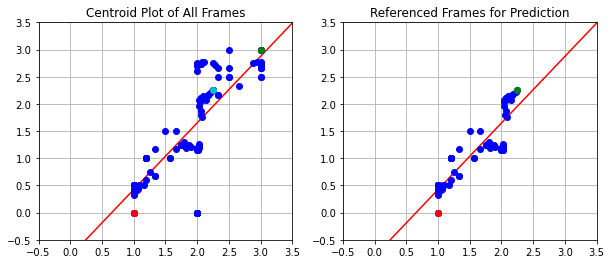

In [32]:
#################################
#Pathing Algorithm Testing


# button debounce
while button.read() != 0 :
    time.sleep(0.05)
    
print("Starting data acquisition.\nPress any PYNQ-Z2 button to end.")
idx = 0
idx2 = 0
data_array = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Icx = []
Icy = []
Imax = 0

x_data = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
y_data = [3,2,1,0,3,2,1,0,3,2,1,0,3,2,1,0]

while button.read() == 0:
    
    frog_control.write(0x0, eye_index[idx])
    
    if (idx < 16) :
        adc = xfer([0x1001], spi)
        num = adc[0]
        num = num >> 4
        
        if idx > 0:
            data_array[idx-1] = num
        else:
            #print(data_array)
            data_array[15] = 2048
    
    if idx % 4 == 3:
        frog_control.write(0x0, eye_rst[idx2])
        idx2 += 1
    
    idx = idx + 1
    
    if (idx == 16) :
        print(data_array,end='\r')
        
        #Centroid from array
        PM = data_array.index(max(data_array))
        data_mod = [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048]
        
        for i in range(3):
            for j in range(3):
                p = PM-5+j+4*i

                if p < 0 or p > 15:
                    continue
                if PM % 4 == 0 and j == 0:
                    continue
                elif PM % 4 == 3 and j == 2:
                    continue

                if p == PM:
                    data_mod[p] = data_array[p]
                else:  
                    data_mod[p] = (data_array[p]-2048)*1+2048
        
        #print(data_mod,end='\r')
        
        Itot = 0
        Ix = [0,0,0]
        Iy = [0,0,0]
        
        for x in data_mod:
            Itot += x-2048
        
        for j in range(3):
            for i in range(4):
                Iy[j] += data_mod[4*i-j+2]-2048

        for j in range(3):
            for i in range(4):
                Ix[j] += data_mod[4*j+i+4]-2048

        if Itot != 0:
            Icx.append((Ix[0]+2*Ix[1]+3*Ix[2])/Itot)
            Icy.append((Iy[0]+2*Iy[1]+3*Iy[2])/Itot)
            if Itot > Imax:
                Imax = Itot
                data_max = [x - 2048 for x in data_mod]
        
        idx = 0
        idx2 = 0
        

print("Acquition end")
print(f'Frame count is: {len(Icx)}')

IcxM = []
IcyM = []

fp = 100
try:
    for x in range(fp):
        IcxM.append(Icx[x-fp])
        IcyM.append(Icy[x-fp])


    m, b, r, p, std_err = stats.linregress(IcxM, IcyM)
    xp = 2*IcxM[-1]-IcxM[0]
    yp = m*xp+b
    print(f'Likely next location at: ({xp},{yp})')
except:
    print("Not enough data to predict path")
    
fig = plt.figure(figsize=plt.figaspect(.4))
ax = fig.add_subplot(1,2,1)

plt.plot(Icx, Icy, 'bo', label="Frame Centroids", zorder=3)
plt.plot(Icx[0], Icy[0], 'go', label="Initial Point", zorder=4)
try:
    plt.plot([-1,4], [-m+b,4*m+b], 'r-', label="Linear Fit", zorder=2)
    plt.plot(xp, yp, 'mo', label="Likely Next Location in 1 sec", zorder = 5)
    plt.plot(Icx[-100], Icy[-100], 'co', label="Start of LF", zorder = 6)
    plt.plot(Icx[-1], Icy[-1], 'ro', label="End of LF", zorder = 7)
    print("LF printed")
except:
    print("Not enough data to predict path")
plt.grid()
plt.xlim([-0.5,3.5])
plt.ylim([-0.5,3.5])
#plt.legend()
plt.title('Centroid Plot of All Frames')

ax = fig.add_subplot(1,2,2)

plt.plot(IcxM, IcyM, 'bo', label="Frame Centroids", zorder=3)
plt.plot(IcxM[0], IcyM[0], 'go', label="Initial Point", zorder=4)
try:
    plt.plot([-1,4], [-m+b,4*m+b], 'r-', label="Linear Fit", zorder=2)
    plt.plot(xp, yp, 'mo', label="Likely Next Location in 1 sec", zorder = 5)
    plt.plot(IcxM[-1], IcyM[-1], 'ro', label="End of LF", zorder = 6)
    print("LF printed 2")
except:
    print("Not enough data to predict path")
plt.grid()
plt.xlim([-0.5,3.5])
plt.ylim([-0.5,3.5])
#plt.legend()
plt.title('Referenced Frames for Prediction')

plt.show()